In [290]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import plot, init_notebook_mode, iplot
import cufflinks as cf
cf.go_offline()
sns.set(color_codes=True)

In [109]:
league_id = 119974
prev_year = 2019

prev_url = "https://fantasy.espn.com/apis/v3/games/ffl/leagueHistory/" + \
      str(league_id) + "?seasonId=" + str(prev_year)

current_url = 'https://fantasy.espn.com/apis/v3/games/ffl/seasons/2019/segments/0/leagues/' + str(league_id)

teams = requests.get(current_url, cookies).json()
matches = requests.get(current_url, params={"view": "mMatchup"}).json()

In [267]:
df = [[
        game['matchupPeriodId'],
        game['home']['teamId'], game['home']['totalPoints'],
        game['away']['teamId'], game['away']['totalPoints']
    ] for game in matches['schedule']]
df = pd.DataFrame(df, columns=['Week', 'Team1', 'Score1', 'Team2', 'Score2'])
df['Type'] = ['Regular' if w<=14 else 'Playoff' for w in df['Week']]
df.head()

,Week,Team1,Score1,Team2,Score2,Type
0,1,3,84.06,9,86.92,Regular
1,1,11,130.32,1,128.06,Regular
2,1,8,85.34,7,110.92,Regular
3,1,2,84.16,12,116.12,Regular
4,1,6,105.92,5,150.40,Regular


In [284]:
id_to_names = {}
for i in teams['teams']:
    id_to_names[i['id']] = i['location'] + ' ' + i['nickname']

In [281]:
df3 = df.assign(Margin1 = df['Score1'] - df['Score2'],
                Margin2 = df['Score2'] - df['Score1'])
df3 = (df3[['Week', 'Team1', 'Margin1', 'Type']]
 .rename(columns={'Team1': 'Team', 'Margin1': 'Margin'})
 .append(df3[['Week', 'Team2', 'Margin2', 'Type']]
 .rename(columns={'Team2': 'Team', 'Margin2': 'Margin'}))
)
df3.head()

,Week,Team,Margin,Type
0,1,3,-2.86,Regular
1,1,11,2.26,Regular
2,1,8,-25.58,Regular
3,1,2,-31.96,Regular
4,1,6,-44.48,Regular


In [282]:
margins = df3.replace({'Team':id_to_names})
margins = margins[margins.Margin != 0]

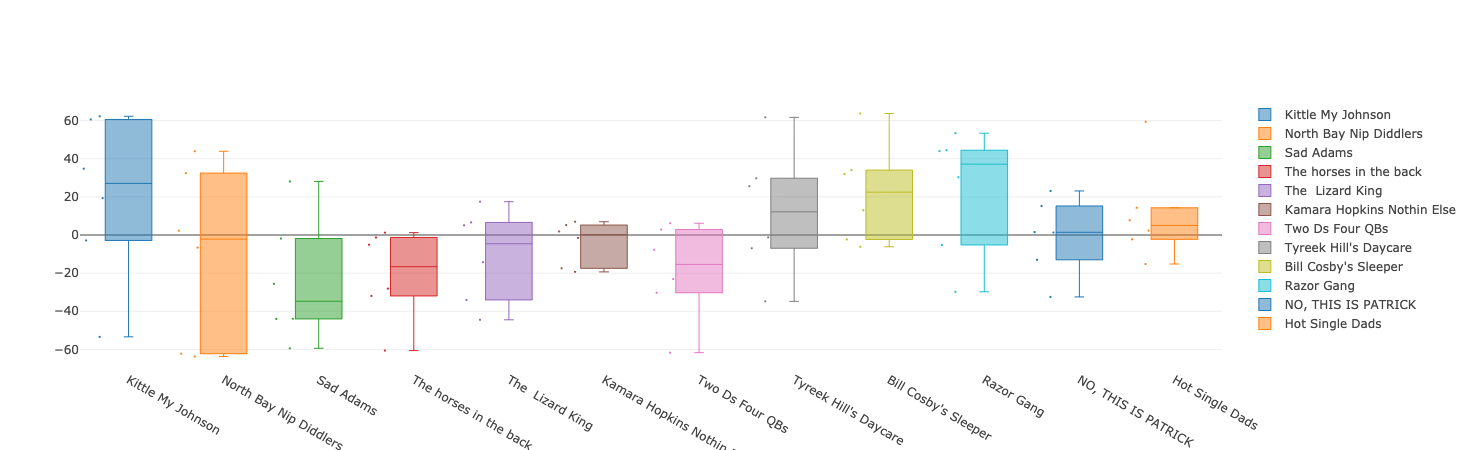

In [285]:
traces = []

for i in margins.Team.unique():
    traces.append(go.Box(
        y=margins[margins.Team == i].Margin
        ,name = i
        ,boxpoints='all'
        ,jitter=0.5
        ,whiskerwidth=0.2
        ,marker=dict(size=2)
        ,line=dict(width=1)
    ))
iplot(traces)

In [331]:
avgs = (df
 .filter(['Week', 'Score1', 'Score2'])
 .melt(id_vars=['Week'], value_name='Score')
 .groupby('Week')
 .mean()
 .reset_index()
)
avgs = avgs[avgs.Week < 7]
print(avgs)


   Week       Score
0     1  106.576667
1     2   96.968333
2     3  112.088333
3     4   94.213333
4     5  113.701667
5     6  103.670000


In [341]:
games = df.replace({'Team1': id_to_names})
games = games.replace({'Team2': id_to_names})
games = (games[['Week', 'Team1', 'Score1']]
 .rename(columns={'Team1': 'Team', 'Score1': 'Score'})
 .append(games[['Week', 'Team2', 'Score2']]
 .rename(columns={'Team2': 'Team', 'Score2': 'Score'}))
)
games = games[games.Week < 7]
games = games.sort_values(by=['Week'])

In [370]:
# data=[go.Scatter(
# #                 marker_color=games['Team'],
#                 text=games['Team'])] # hover text goes here
# iplot(data)

trace = go.Scatter(
    x = games['Week'],
    y = games['Score'],
    mode = 'markers',
    text = games['teams']
)

data = [trace]

# Plot and embed in ipython notebook!
iplot(data, filename='basic-scatter')

KeyError: 'teams'